In [ ]:
!pip install -q kaggle --quiet


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sripaadsrinivasan/audio-mnist

 99% 942M/948M [00:08<00:00, 168MB/s]
100% 948M/948M [00:08<00:00, 117MB/s]


In [ ]:
!unzip audio-mnist.zip

In [ ]:
import numpy as np 
import pandas as pd

import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

In [ ]:
output_dir = '/content/working/'
input_dir = '/content/data/01/'


In [ ]:
input_dir

'/content/data/01/'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
BATCH_SIZE = 256 
EPOCHS = 5
LR = 1e-3 #learning rate

In [ ]:
feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])

In [ ]:
# Define a function to compute the mel spectrogram of an audio file given its path
def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)

 #a function to plot the mel spectrogram of a given audio feature
def imgSpec(ms_feature):
  # Display the mel spectrogram as an image
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');

# a function to play the audio of a given path  
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    
    print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))
    
#a function to get information about a given audio file    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    if label is not None:
        print("Label:", label)
    if show_melspec is not False:
        imgSpec(spec)
    hear_audio(path)

(128, 33)
	

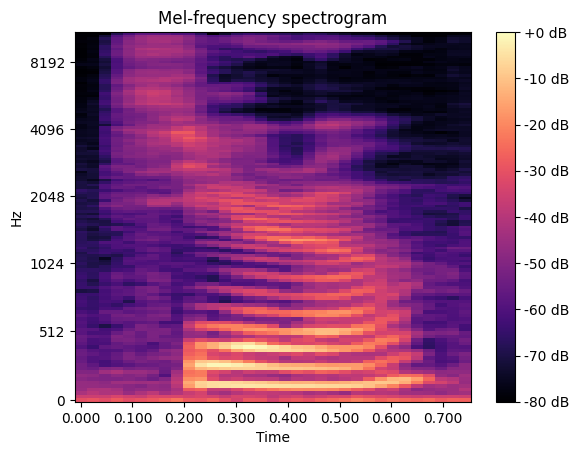

In [ ]:
get_audio_info('/content/data/01/0_01_0.wav', show_melspec=True)

In [ ]:


# a function to compute the mel spectrogram of an audio file given its path
def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)

#a PyTorch dataset class for audio files
class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        """
        Args:
            path (str): Path to directory containing audio files
            feature_transform (callable, optional): Transform to apply to features
            label_transform (callable, optional): Transform to apply to labels
            train (bool, optional): Whether to use the training or validation set
            train_size (float, optional): Percentage of data to use for training (default: 0.80)
        """
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        # Traverse the directory to find audio files and their labels
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        total_len = len(self.file_list)
        # Split the dataset into training and validation sets
        if train:
            self.file_list, self.label_list = self.file_list[:int(train_size * total_len)], self.label_list[:int(train_size * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(train_size * total_len):], self.label_list[int(train_size * total_len):]

    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
    
    def __len__(self):
        return len(self.file_list)


In [ ]:
train_df = AudioDataset('/content/data', 
                        feature_transform=feature_transform, label_transform=T.ToTensor(), train=True)

test_df = AudioDataset('/content/data',
                       feature_transform=feature_transform, label_transform=T.ToTensor(), train=False)

In [ ]:
print(len(train_df), len(test_df))

24000 6000


In [ ]:
#creating dataloaders to load data and label in batches
train_dataloader = DataLoader(train_df, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=BATCH_SIZE, shuffle=True)

trainimages, trainlabels, traintext = next(iter(train_dataloader))
trainimages.shape, trainlabels.shape

(torch.Size([256, 1, 200, 200]), torch.Size([256]))

Label: 4
(128, 21)
	

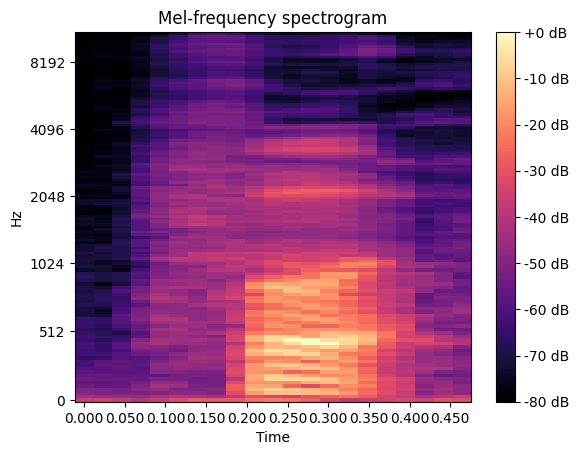

In [ ]:
# one of the datapoints
check = 23
get_audio_info(traintext[check], True, trainlabels[check].item())

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        # Define the convolutional layer sequence
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//4, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )
        
        # Define the fully connected layers
        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )
        
    def forward(self, x):
        # Pass the input through the convolutional layer
        a = self.conv_layer(x)
        
        # Pass the output of the convolutional layer through the fully connected layers
        for layer in self.classifier:
            a = layer(a)
        
        # Return the output as logits
        return a


In [ ]:
#declaring the number of feature maps and CNN layers
num_feature_maps = 256
layers = [484, 128, 64, 32, 10]

In [ ]:
ClassF = AudioClassifier(num_feature_maps, layers).to(device)
ClassF

AudioClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): ModuleList(
    (0): Linear(in_features=484, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
optim = torch.optim.Adam(lr=LR, params=ClassF.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()
    for batch, (X,y,txt) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        
        
        y_logits = model(X).to(device)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)
        
        acc = accuracy_fn(y_preds, y)
        loss = loss_fn(y_logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        train_acc += acc
        
        if batch % 50 == 0:
            sample = random.randint(0, BATCH_SIZE-2)
            print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train accuracy : {acc:.2f}%")
            get_audio_info(txt[sample], label=y_preds[sample].item())
            print("----------------------------------------")
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



def eval_step(model, dataloader, optim, loss_fn, accuracy_fn):
    test_loss = 0.0
    test_acc = 0.0
    
    model.eval()
    with torch.inference_mode():
        for batch, (X,y,txt) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
        
            y_logits = model(X).to(device)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

            acc = accuracy_fn(y_preds, y)
            loss = loss_fn(y_logits, y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 50 == 0:
                sample = random.randint(0, BATCH_SIZE-2)
                print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test accuracy : {acc:.2f}%")
                get_audio_info(txt[sample], label=y_preds[sample].item())
                print("----------------------------------------")
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    train_step(ClassF, train_dataloader, optim, loss_fn, accuracy)
    eval_step(ClassF, test_dataloader, optim, loss_fn, accuracy)

Epoch 0
	Batch 0: Train loss: 2.29703 | Train accuracy : 10.94%
Label: 8
	

----------------------------------------
	Batch 50: Train loss: 0.13990 | Train accuracy : 96.09%
Label: 3
	

----------------------------------------
Train loss: 0.47776 | Train accuracy: 84.81%
	Batch 0: Test loss: 2.08538 | Test accuracy : 47.66%
Label: 2
	

----------------------------------------
Test loss: 2.21501 | Test accuracy: 45.08%
Epoch 1
	Batch 0: Train loss: 0.13472 | Train accuracy : 96.48%
Label: 9
	

----------------------------------------
